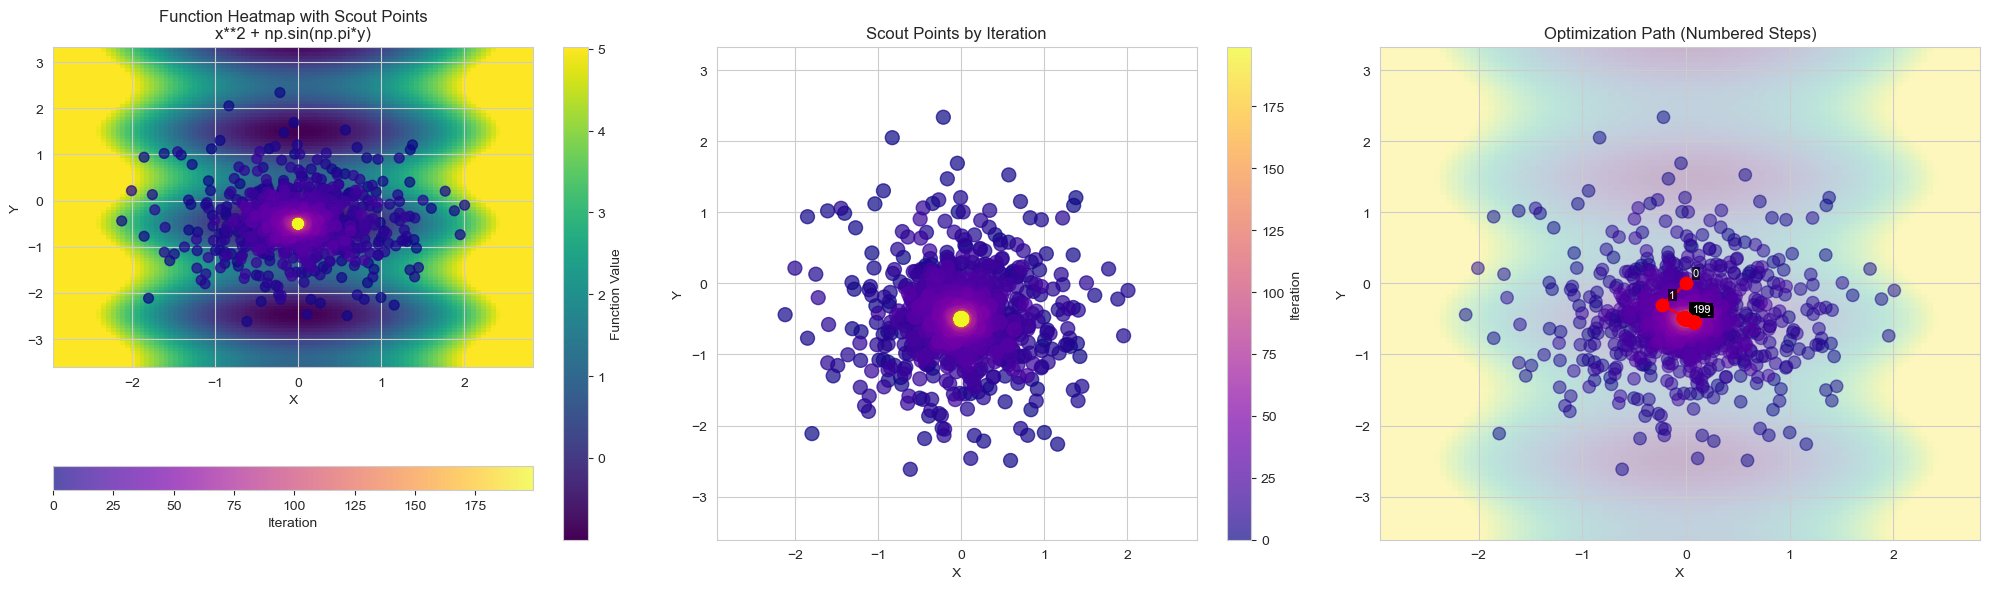

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

def generate_scouts(origin, scouts, distance, seed=10110101):
    """Generate scout points randomly distributed around the origin."""
    np.random.seed(seed)
    dims = len(origin)
    coordinate_set = []
    for _ in range(scouts):
        coordinate = [origin[j] + np.random.normal(0, distance) for j in range(dims)]
        coordinate_set.append(coordinate)
    return coordinate_set

def NUMERIC_MAX_MIN(a, b, use_max):
    """Simple helper function to return numeric max or min based on flag"""
    return max(a, b) if use_max else min(a, b)

def MADS(objective, mode, itmax=100, delta=1, scouts=20):
    """Mesh Adaptive Direct Search (MADS) for optimization"""
    origin = [0, 0]
    best_coordinate = origin[:]
    coordinate_set = generate_scouts(best_coordinate, scouts, delta)
    best_optima = objective(origin)
    new_optima = best_optima
    
    all_scouts = []
    best_path = []
    
    seed = 1
    
    for it in range(itmax):
        best_path.append(best_coordinate)
        for scout in coordinate_set:
            all_scouts.append({
                "x": scout[0], 
                "y": scout[1], 
                "iteration": it,
                "value": objective(scout)
            })
            
        best_optima = objective(best_coordinate)
        for scout in coordinate_set:
            curr_evaluation = objective(scout)
            new_optima = NUMERIC_MAX_MIN(best_optima, curr_evaluation, mode)
            if new_optima != best_optima:
                best_coordinate = scout
                best_optima = new_optima
        
        delta *= 0.95
        coordinate_set = generate_scouts(best_coordinate, scouts, delta, seed)
        seed += 1
    
    return best_optima, pd.DataFrame(all_scouts), pd.DataFrame({
        "x": [p[0] for p in best_path], 
        "y": [p[1] for p in best_path],
        "step": range(len(best_path))
    })

def objective_function(point):
    x, y = point
    return x**2 + np.sin(np.pi*y + x)

# Run MADS on the function
best_value, scouts_df, path_df = MADS(objective_function, mode=False, itmax=200, scouts=30)

# Calculate dynamic ranges based on scout movements
x_min, x_max = scouts_df['x'].min(), scouts_df['x'].max()
y_min, y_max = scouts_df['y'].min(), scouts_df['y'].max()

# Add some padding to the ranges
padding = 0.2
x_range = x_max - x_min
y_range = y_max - y_min
x_min -= x_range * padding
x_max += x_range * padding
y_min -= y_range * padding
y_max += y_range * padding

# Create function visualization data with dynamic ranges
x = np.linspace(x_min, x_max, 100)
y = np.linspace(y_min, y_max, 100)
X, Y = np.meshgrid(x, y)
Z = X**2 + np.sin(np.pi*Y)

# Calculate function value limits for consistent colormap
z_min = scouts_df['value'].min()
z_max = scouts_df['value'].max()
Z = np.clip(Z, z_min, z_max)  # Clip values to the actual range of interest

# Create the visualization
fig = plt.figure(figsize=(20, 6))
gs = plt.GridSpec(1, 3, width_ratios=[1, 1, 1])

# Function heatmap with viridis colormap
ax0 = fig.add_subplot(gs[0])
heatmap = ax0.imshow(Z, extent=[x_min, x_max, y_min, y_max], 
                     origin='lower', cmap='viridis', aspect='auto')
scatter0 = ax0.scatter(scouts_df['x'], scouts_df['y'], 
                      c=scouts_df['iteration'], 
                      cmap='plasma',
                      s=50, alpha=0.7, label='Scouts')
ax0.set_title("Function Heatmap with Scout Points\nx**2 + np.sin(np.pi*y)")
ax0.set_xlabel("X")
ax0.set_ylabel("Y")
plt.colorbar(heatmap, ax=ax0, label='Function Value')
plt.colorbar(scatter0, ax=ax0, label='Iteration', orientation='horizontal', pad=0.2)

# Scatter plot of all scout points colored by iteration
ax1 = fig.add_subplot(gs[1])
scatter = ax1.scatter(scouts_df['x'], scouts_df['y'], 
                     c=scouts_df['iteration'], 
                     cmap='plasma',
                     s=100, alpha=0.7, label='Scouts')
ax1.set_title("Scout Points by Iteration")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_xlim([x_min, x_max])
ax1.set_ylim([y_min, y_max])
plt.colorbar(scatter, ax=ax1, label='Iteration')

# Best path progression with numbered points
ax2 = fig.add_subplot(gs[2])
ax2.imshow(Z, extent=[x_min, x_max, y_min, y_max], 
           origin='lower', cmap='viridis', aspect='auto', alpha=0.3)
ax2.scatter(scouts_df['x'], scouts_df['y'], 
           c=scouts_df['iteration'], cmap='plasma',
           s=80, alpha=0.5, label='Scouts')
ax2.plot(path_df['x'], path_df['y'], 'r-', alpha=0.8, linewidth=2)

# Add numbered points along the path with better visibility
for idx, row in path_df.iterrows():
    ax2.annotate(str(idx), (row['x'], row['y']), 
                 xytext=(5, 5), textcoords='offset points',
                 fontsize=8, color='white',
                 bbox=dict(facecolor='black', alpha=0.7, edgecolor='none', pad=1))
ax2.scatter(path_df['x'], path_df['y'], c='red', s=80, zorder=5)
ax2.set_title("Optimization Path (Numbered Steps)")
ax2.set_xlabel("X")
ax2.set_ylabel("Y")
ax2.set_xlim([x_min, x_max])
ax2.set_ylim([y_min, y_max])

plt.tight_layout()
plt.show()

In [4]:
scouts_df

,x,y,iteration,value
0,-1.030443,-0.314512,0,0.226848
1,-0.038075,1.008204,0,-0.024320
2,-1.406661,0.987038,0,2.019407
3,0.453076,-0.724560,0,-0.556025
4,-0.005455,-0.184688,0,-0.548173
...,...,...,...,...
5995,-0.000063,-0.499978,199,-1.000000
5996,-0.000022,-0.500019,199,-1.000000
5997,-0.000005,-0.500013,199,-1.000000
5998,0.000057,-0.500007,199,-1.000000


c:\ProgramData\anaconda3\envs\Coffee_cuda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\envs\Coffee_cuda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


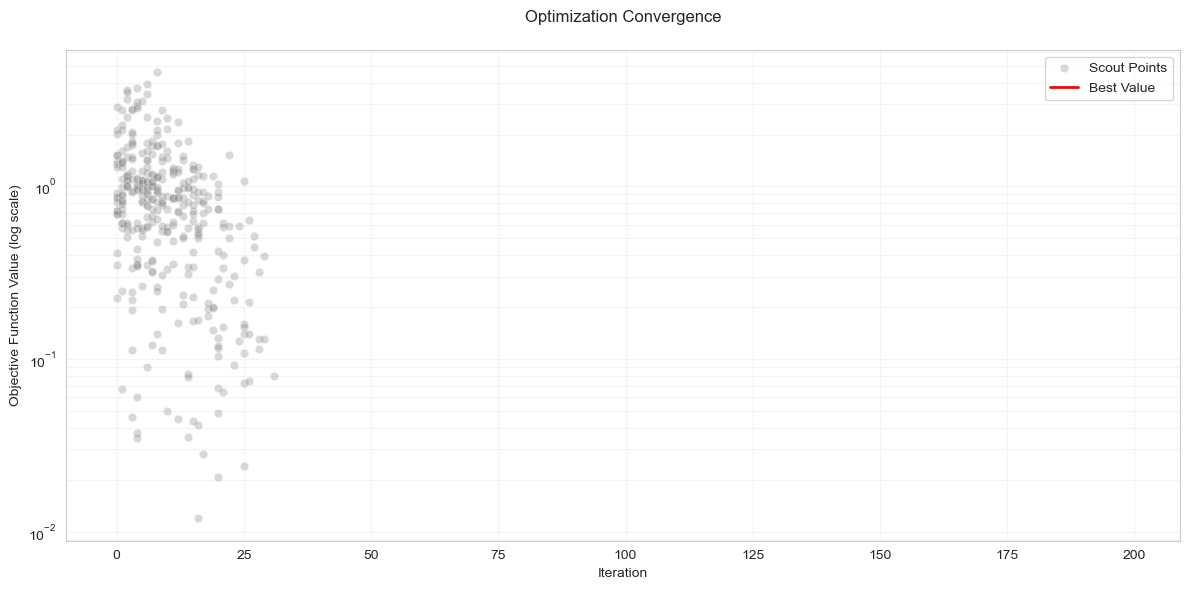

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create the plot
plt.figure(figsize=(12, 6))

# Create main scatter plot of all points
sns.scatterplot(data=scouts_df, 
                x='iteration', 
                y='value',
                alpha=0.3,
                color='gray',
                label='Scout Points')

# Add trend line showing minimum value per iteration
min_per_iteration = scouts_df.groupby('iteration')['value'].min().reset_index()
sns.lineplot(data=min_per_iteration,
            x='iteration',
            y='value',
            color='red',
            linewidth=2,
            label='Best Value')

# Customize the plot
plt.yscale('log')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.title('Optimization Convergence', pad=20)
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value (log scale)')

# Add styling
sns.set_style("whitegrid")
plt.legend(title='', loc='upper right')

plt.tight_layout()
plt.show()